# 2019-01-29 - Réseau récurrent à double anneau
L'idée c'est de partir sur un modèle modulaire de colonne cortical, notre ring actuel, et d'en distribuer plusieurs le long d'un ring topologique. C'est la première étape vers le fait de pouvoir faire un joli salt and pepper vs topologique pour jouer chat/souris, plutot que de faire une méga couche L4 comme on fait maintenant.

In [1]:
import numpy as np
import pyNN.nest as sim
from pyNN.random import NumpyRNG
from pyNN.random import RandomDistribution as rnd
import matplotlib.pyplot as plt
from lmfit.models import GaussianModel
import lmfit
import matplotlib.gridspec as gridspec

CSAConnector: libneurosim support not available in NEST.
Falling back on PyNN's default CSAConnector.
Please re-compile NEST using --with-libneurosim=PATH


/home/hugo/anaconda3/lib/python3.7/site-packages/PyNN-0.9.2-py3.7.egg/pyNN/nest/__init__.py:55: UserWarning: Unable to install NEST extensions. Certain models may not be available.
Further details: DynamicModuleManagementError in Install: Module 'pynn_extensions' could not be opened.
The dynamic loader returned the following error: 'file not found'.

Please check LD_LIBRARY_PATH (OSX: DYLD_LIBRARY_PATH)!
  warnings.warn("Unable to install NEST extensions. Certain models may not be available.\nFurther details: {}".format(err))


# Testing the new topology, graphically

In [2]:
from pyNN.space import *

class BigRingTopology(BaseStructure):
    parameter_names = 'radius'

    def __init__(self, radius):
        self.radius = radius

    def generate_positions(self, n):
        return np.array([
            np.cos(np.linspace(0, 2*np.pi, n))*(self.radius-1),
            np.sin(np.linspace(0, 2*np.pi, n))*(self.radius-1),
            np.zeros(n)
        ])
        # must return a 3xn numpy array
        
class SmallRingTopology(BaseStructure):
    '''
    The inner, smaller ring, that is distributed along the bigger ring
    '''
    parameter_names = 'radius'

    def __init__(self, radius, center):
        self.radius = radius
        self.center = center
        self.center_x = center[0]
        self.center_y = center[1]
        
    def generate_positions(self, n):
        return np.array([
            np.cos(np.linspace(0, 2*np.pi, n))*(self.radius-1)+self.center_x,
            np.sin(np.linspace(0, 2*np.pi, n))*(self.radius-1)+self.center_y,
            np.zeros(n)
        ])
        # must return a 3xn numpy array

Text(0.5, 1.0, 'Multiple ring scattering')

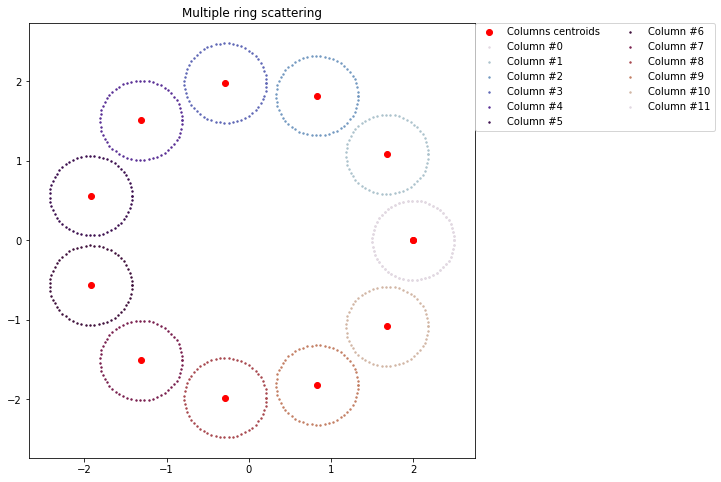

In [3]:
plt.figure(figsize = (8,8))

n_positions = 12
colors=plt.cm.twilight(np.linspace(0,1,12))

bigring = BigRingTopology(radius = 3)
bigpos = bigring.generate_positions(n_positions)
plt.scatter(bigpos[0], bigpos[1], color = 'r', label = 'Columns centroids')

for position in range(n_positions):
    center = (bigpos[0][position],bigpos[1][position])
    smallring = SmallRingTopology(radius=1.5, center = center)
    smallpos = smallring.generate_positions(60)
    smallpos.shape

    plt.scatter(smallpos[0], smallpos[1], color = colors[position],label = 'Column #%s'%position,
                s = 2)
    
plt.legend(ncol = 2, loc = (1,.752))
plt.title('Multiple ring scattering')

# Testing the new topology, functionally

In [4]:
def tuning_function(x, j, B, fmax):  # von mises
    N = len(x)
    if B == np.inf:
        VM = np.ones_like(x)
    else:
        VM = np.exp((np.cos(2.*np.pi*(x-j)/N)-1.)/4/(B*np.pi/180)**2)
    #VM /= VM.sum(axis=0)
    return fmax * VM


def fit_plot(popsize, spike_array, ax, datacol='.r', fitcol='--k', data_kws=None, do_title=True,
             seq_nbr=None):
    '''
    calculates a spike array gaussian lmfit profile and plots it
    '''

    # fit the gaussian
    x = np.linspace(0, popsize, popsize)
    y = spike_array
    N = len(spike_array)

    #mod = GaussianModel()
    from lmfit import Model, Parameters
    mod = Model(tuning_function)
    pars = Parameters()
    pars.add_many(('j', y.argmax(), True,  0.0, N), ('B', 15., True,  0.1, 360),
                  ('fmax', y.max(), True,  0.0, 200.))

    #pars = mod.guess(y, x=x)
    #pars['center'] = lmfit.Parameter('center', seq_nbr*15)
    out = mod.fit(y, pars, x=x, nan_policy='omit')
    # print(out.fit_report(min_correl=0.25))

    # plot the fits
    out.plot_fit(ax=ax, datafmt=datacol, fitfmt=fitcol,
                 data_kws=data_kws, show_init=False)

    sigma = out.best_values['B']

    if do_title:
        ax.set_title('Sequence #%s -- ' % seq_nbr + r'$B_\theta$ = %.2f' % sigma)

    return ax, sigma


def cut_spiketrain(array, window, total_time, nbr_window):
    '''
    Cut a spiketrain array between window*500 and window+1 *500
    we use it to only visualize a specific time window of the network
    '''
    spiketrain_len = []
    for spiketrain in np.asarray(array.spiketrains):
        spiketrain_array = np.array(spiketrain, dtype=float)

        spiketrain_cut = np.where(
            (spiketrain_array > window*int(total_time/nbr_window)) & (spiketrain_array < (window+1)*int(total_time/nbr_window)))[0]

        spiketrain_len.append(len(spiketrain_cut))

    spikelen_array = np.asarray(spiketrain_len)
    return spikelen_array

In [5]:
def SuperPlotter(SpikesP, SpikesE, SpikesI,
                 popsize, simtime, nbr_window,
                 title='Title', markersize=.5,
                 figsize=(9, 6), shifts=None):
    # oh la jolie double fonction
    def plot_spiketrains(ax, spikes, color, ylabel, do_ticks):
        for spiketrain in spikes.spiketrains:
            y = np.ones_like(spiketrain) * spiketrain.annotations['source_id']
            ax.scatter(spiketrain, y, color=color, s=markersize)
            ax.set_ylabel(ylabel)
            if not do_ticks:
                ax.set_xticklabels([])
            if shifts != None:
                for i, times in enumerate(shifts):
                    ax.axvline(x=times, color='k',
                               linestyle='-.', linewidth=1)

    fig = plt.figure(figsize=figsize)
    gs = gridspec.GridSpec(5, 8)
    axs1 = plt.subplot(gs[0, :4])
    axs2 = plt.subplot(gs[1, :4])
    axs3 = plt.subplot(gs[2, :4])

    axs4 = plt.subplot(gs[0:1, 4:6])
    axs5 = plt.subplot(gs[0:1, 6:8])
    axs6 = plt.subplot(gs[1:2, 4:6])
    axs7 = plt.subplot(gs[1:2, 6:8])
    axs8 = plt.subplot(gs[2:3, 4:6])
    axs9 = plt.subplot(gs[2:3, 6:8])

    # what a fucking mess
    min_poisson = int(SpikesP.description.split('ID range')[
                      1].split('\n')[0].split(': ')[1].split('-')[0])
    max_poisson = int(SpikesP.description.split('ID range')[
                      1].split('\n')[0].split(': ')[1].split('-')[1])
    axs1.set_ylim(min_poisson, max_poisson)
    
    #input
    plot_spiketrains(axs1, SpikesP, color='g',
                     ylabel='Neurone', do_ticks=False)
    axs1.set_title('Entrée de Poisson')
    #ring1
    plot_spiketrains(axs2, SpikesI, color='b',
                     ylabel='Neurone', do_ticks=False)
    axs2.set_title('Pop. Inhibitrice')
    plot_spiketrains(axs3, SpikesE, color='r',
                     ylabel='Neurone', do_ticks=True)
    axs3.set_title('Pop. Excitatrice')

    axs3.set_xlabel('Temps (ms)')
    
    #output and coding from ring 1
    axs4.plot(cut_spiketrain(SpikesP, 0,simtime, nbr_window), color='g')
    fit_plot(popsize, cut_spiketrain(SpikesE, 0,simtime, nbr_window), axs4, seq_nbr=1)[1]
    axs4.set_xticklabels([])
    axs4.set_yticklabels([])
    axs4.set_xlabel('')
    axs4.set_ylabel('')

    axs6.plot(cut_spiketrain(SpikesP, 1,simtime, nbr_window), color='g')
    fit_plot(popsize, cut_spiketrain(SpikesE, 1,simtime, nbr_window), axs6, seq_nbr=2)[1]
    axs6.set_xticklabels([])
    axs6.set_yticklabels([])
    axs6.set_xlabel('')
    axs6.set_ylabel('')

    axs8.plot(cut_spiketrain(SpikesP, 2,simtime, nbr_window), color='g')
    fit_plot(popsize, cut_spiketrain(SpikesE, 2,simtime, nbr_window), axs8, seq_nbr=3)[1]
    axs8.set_xticklabels([])
    axs8.set_yticklabels([])
    axs8.set_xlabel('')
    axs8.set_ylabel('')

    axs5.plot(cut_spiketrain(SpikesP, 3,simtime, nbr_window), color='g')
    fit_plot(popsize, cut_spiketrain(SpikesE, 3,simtime, nbr_window), axs5, seq_nbr=4)[1]
    axs5.set_xticklabels([])
    axs5.set_yticklabels([])
    axs5.set_xlabel('')
    axs5.set_ylabel('')
    
    axs7.plot(cut_spiketrain(SpikesP, 4,simtime, nbr_window), color='g')
    fit_plot(popsize, cut_spiketrain(SpikesE, 4,simtime, nbr_window), axs7, seq_nbr=5)[1]
    axs7.set_xticklabels([])
    axs7.set_yticklabels([])
    axs7.set_xlabel('')
    axs7.set_ylabel('')
    
    axs9.plot(cut_spiketrain(SpikesP, 5,simtime, nbr_window), color='g')
    fit_plot(popsize, cut_spiketrain(SpikesE, 5,simtime, nbr_window), axs9, seq_nbr=6)[1]
    axs9.set_xticklabels([])
    
    axs9.yaxis.tick_right()
    axs9.yaxis.set_label_position("right")
    axs9.set_xlabel('Neurone')
    axs9.set_ylabel('Nombre de P.A.')
    
    axs9.legend(labels=['Entrée', 'Exc.', 'VonMises'])

    fig.suptitle(title, fontsize=12)
    plt.show()
    return fig

On défini les paramètres de simulations

In [6]:
n_pop = 60
neuron_parameters = {'cm': .5,  # nF - McCormick
                     'e_rev_E': 0.0,  # mV - McCormick but default values
                     'e_rev_I': -70.0,  # mV - McCormick but default values
                     'tau_m': 30,  # ms - Markram
                     'tau_refrac': 1.5,  # ms - McCormick
                     'tau_syn_E': 0.25,  # ms -McCormick
                     'tau_syn_I': 0.75,  # ms - McCormick
                     'v_reset': -56.5,  # mV - McCormick
                     'v_rest': -65.5,  # mV - McCormick
                     'v_thresh': -52.5,  # mV - McCormick
                     }

simtime = 3000
rng = sim.NumpyRNG(seed=42)

rate_gain = 20.  # multiplier for the rates
angle_input = 40  # degrees
b_theta = 15  # degrees

Et on fait tourner la simulation

In [7]:
stdp_weight_init = .1
stdp_max_w = 2 * stdp_weight_init
normal_weights = stdp_weight_init
nbr_window = 6
delays = rnd('normal_clipped', mu=3, sigma=5, low=0.1,
             high=5,
             rng=rng)

# la stdp normale
causal_hebian_timing_dependence = sim.SpikePairRule(tau_plus=30.*1.25, tau_minus=30.,
                                                    A_plus=.025*1.5, A_minus=.025)
# la stdp à l'envers
anticausal_hebian_timing_dependence = sim.SpikePairRule(tau_plus=30.*.75, tau_minus=30.,
                                                        A_plus=-.025*0.3, A_minus=-.025)
# la symétrique positive
causal_sym_timing_dependence = sim.SpikePairRule(tau_plus=30.*1.6, tau_minus=30.,
                                                 A_plus=.025, A_minus=-.025)
# la symétrique négative
anticausal_sym_timing_dependence = sim.SpikePairRule(tau_plus=30.*1, tau_minus=30.,
                                                     A_plus=-.025*1.75, A_minus=.025)

In [8]:
n_positions = 12

bigring = BigRingTopology(radius = 3)
bigpos = bigring.generate_positions(n_positions)

topology_list = []
for position in range(n_positions):
    center = (bigpos[0][position],bigpos[1][position])
    smallring = SmallRingTopology(radius=1.5, center = center)
    smallpos = smallring.generate_positions(60)
    topology_list.append(smallring)

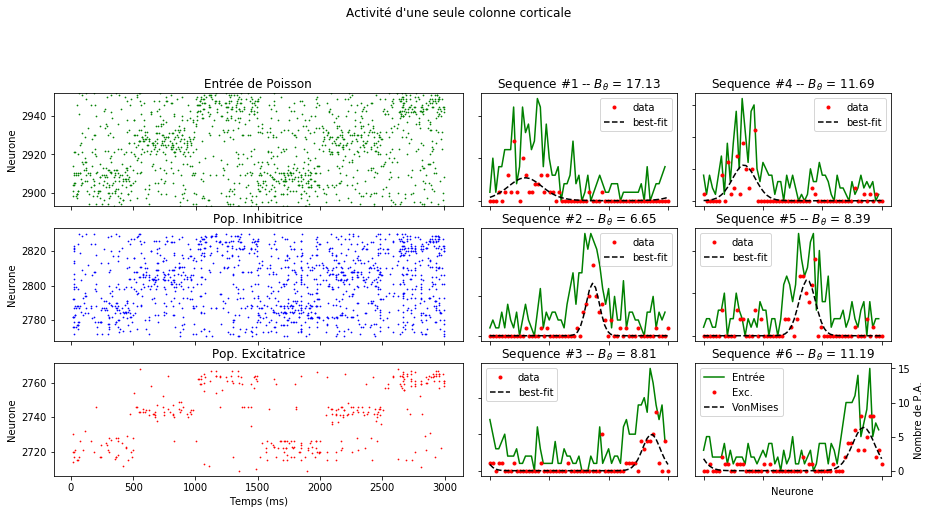

In [9]:
sim.setup(timestep=.1, threads=8)

# INPUT STDP
in_mult = 4
# input to exc, causal hebbian
in_causal_STDP_syn = sim.STDPMechanism(
    timing_dependence=causal_hebian_timing_dependence,
    weight_dependence=sim.MultiplicativeWeightDependence(
        w_min=0, w_max=in_mult*stdp_max_w),
    weight=in_mult*stdp_weight_init,
    delay=delays,
    dendritic_delay_fraction=1.)
# input to inh, anticausal hebbian
in_anticausal_STDP_syn = sim.STDPMechanism(
    timing_dependence=anticausal_hebian_timing_dependence,
    weight_dependence=sim.MultiplicativeWeightDependence(
        w_min=0, w_max=in_mult*stdp_max_w),
    weight=in_mult*stdp_weight_init,
    delay=delays,
    dendritic_delay_fraction=1.)

# CAUSAL STDP
# syn exc_inh, hebbian causality
causal_STDP_syn = sim.STDPMechanism(
    timing_dependence=causal_hebian_timing_dependence,
    weight_dependence=sim.MultiplicativeWeightDependence(
        w_min=0, w_max=stdp_max_w),
    weight=stdp_weight_init,
    delay=delays,
    dendritic_delay_fraction=1.)

# ANTICAUSAL STDP
# syn inh exc, makes the inhibitory fire when exc is not firing
inh_anticausal_STDP_syn = sim.STDPMechanism(
    timing_dependence=anticausal_hebian_timing_dependence,
    weight_dependence=sim.MultiplicativeWeightDependence(
        w_min=0, w_max=-stdp_max_w),
    weight=-stdp_weight_init,
    delay=delays,
    dendritic_delay_fraction=1.)

# SYMETRIC POSITIVE STDP
# syn exc exc, reinforcing
sim_plus_STDP_syn = sim.STDPMechanism(
    timing_dependence=causal_sym_timing_dependence,
    weight_dependence=sim.MultiplicativeWeightDependence(
        w_min=0, w_max=stdp_max_w),
    weight=stdp_weight_init,
    delay=delays,
    dendritic_delay_fraction=1.)
# syn inh inh, reinforcing inhibition
inh_sim_plus_STDP_syn = sim.STDPMechanism(
    timing_dependence=causal_sym_timing_dependence,
    weight_dependence=sim.MultiplicativeWeightDependence(
        w_min=0, w_max=-stdp_max_w),
    weight=-stdp_weight_init,
    delay=delays,
    dendritic_delay_fraction=1.)

for position in range(n_positions):
    center = (bigpos[0][position],bigpos[1][position])
    
    exc = sim.Population(n_pop, sim.IF_cond_exp(**neuron_parameters),
                         initial_values={"v": neuron_parameters["v_reset"]},
                         structure=SmallRingTopology(radius=1.5, center = center),
                         label="Neurones Exictateurs")
    inh = sim.Population(n_pop, sim.IF_cond_exp(**neuron_parameters),
                         initial_values={"v": neuron_parameters["v_reset"]},
                         structure=SmallRingTopology(radius=1.5, center = center),
                         label="Neurones Inhibiteurs")

    input_pop = sim.Population(n_pop,
                               sim.SpikeSourcePoisson(
                                   rate=1500, duration=simtime, start=0),
                               label="Entree Orientation")
    #Connectivity
    # Intras
    syn_exc_exc = sim.Projection(exc, exc,
                                 connector=sim.DistanceDependentProbabilityConnector("exp(2*-d)",
                                                                                     allow_self_connections=False),
                                 synapse_type=sim_plus_STDP_syn)
    syn_inh_inh = sim.Projection(inh, inh,
                                 connector=sim.DistanceDependentProbabilityConnector("exp(2*-d)",
                                                                                     allow_self_connections=False),
                                 synapse_type=inh_sim_plus_STDP_syn)
    # Inters
    syn_exc_inh = sim.Projection(exc, inh,
                                 connector=sim.AllToAllConnector(
                                     allow_self_connections=False),
                                 synapse_type=causal_STDP_syn)
    syn_inh_exc = sim.Projection(inh, exc,
                                 connector=sim.AllToAllConnector(
                                     allow_self_connections=False),
                                 synapse_type=inh_anticausal_STDP_syn)
    # Input
    syn_inp_exc = sim.Projection(input_pop, exc,
                                 connector=sim.OneToOneConnector(),
                                 synapse_type=in_causal_STDP_syn)
    syn_inp_inh = sim.Projection(input_pop, inh,
                                 connector=sim.OneToOneConnector(),
                                 synapse_type=in_anticausal_STDP_syn)

def vary_angle(t):
    #callback function that shifts the maximum angle
    
    b_theta_cop = b_theta
    n_pop = 60
    shift = 40
    noise = .2
    '''if t > 6000 :
        b_theta_cop *=2'''
    angle = 1. * np.arange(n_pop)
    rates = tuning_function(
        angle, (t*shift)+(angle_input)/180.*n_pop, b_theta_cop, rate_gain)
    rates = (1-noise)*rates + noise * rate_gain

    for i, cell in enumerate(input_pop):
        cell.set_parameters(rate=rates[i])

    return t + simtime/nbr_window


exc.record('spikes')
inh.record('spikes')
input_pop.record('spikes')
sim.run(simtime, callbacks=[vary_angle])
sim.end()

exc_data = exc.get_data().segments[0]
inh_data = inh.get_data().segments[0]
inp_data = input_pop.get_data().segments[0]

fig = SuperPlotter(inp_data, exc_data, inh_data,
                   60, simtime, nbr_window,
                   title="Activité d'une seule colonne corticale",
                   figsize=(15, 12))

plt.show()